In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import datetime as dt

## Step 1 - Gathering and Exploring Data

Let us first download the data for 3 ETFs. I am downloading data for the years starting 2012 and until 2022. Of these, the data from 2018 to 2022 will be used for testing.

In [22]:
equity = yf.Ticker("SPY").history(start="2012-01-01", end="2022-12-31")
crude_oil = yf.Ticker("DBO").history(start="2012-01-01", end="2022-12-31")
gold = yf.Ticker("GLD").history(start="2012-01-01", end="2022-12-31")

#extract only the date from the date timestamp
#equity.index = equity.index.date
#crude_oil.index = crude_oil.index.date
#gold.index = gold.index.date

In [24]:
equity.head() #first look at the data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2012-01-03 00:00:00-05:00,100.958320,101.448257,100.697546,100.752861,193697900,0.0,0.0,0.0
2012-01-04 00:00:00-05:00,100.515757,100.997790,100.128551,100.910866,127186500,0.0,0.0,0.0
2012-01-05 00:00:00-05:00,100.365655,101.329717,99.907327,101.179573,173895000,0.0,0.0,0.0
2012-01-06 00:00:00-05:00,101.306006,101.321813,100.586910,100.918800,148050000,0.0,0.0,0.0
2012-01-09 00:00:00-05:00,101.147972,101.290206,100.681746,101.163780,99530200,0.0,0.0,0.0


In [26]:
crude_oil.head() #fist look at the data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2012-01-03 00:00:00-05:00,25.796447,26.094875,25.770116,26.042212,318300,0.0,0.0,0.0
2012-01-04 00:00:00-05:00,25.954440,26.235313,25.884221,26.165094,422800,0.0,0.0,0.0
2012-01-05 00:00:00-05:00,26.015880,26.244090,25.796448,25.814003,249700,0.0,0.0,0.0
2012-01-06 00:00:00-05:00,26.015880,26.015880,25.673566,25.919331,357900,0.0,0.0,0.0
2012-01-09 00:00:00-05:00,25.849113,25.875444,25.550685,25.831558,213900,0.0,0.0,0.0


In [28]:
gold.head() #first look at the gold data etf

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2012-01-03 00:00:00-05:00,154.759995,156.300003,154.550003,155.919998,13385800,0.0,0.0,0.0
2012-01-04 00:00:00-05:00,155.429993,157.380005,155.339996,156.710007,11549700,0.0,0.0,0.0
2012-01-05 00:00:00-05:00,155.369995,158.029999,155.250000,157.779999,11621600,0.0,0.0,0.0
2012-01-06 00:00:00-05:00,158.589996,158.630005,156.380005,157.199997,9790500,0.0,0.0,0.0
2012-01-09 00:00:00-05:00,157.360001,157.589996,156.190002,156.500000,8771900,0.0,0.0,0.0


Let us collect the closing prices for all these 3 ETFs.

In [31]:
equity = equity["Close"]
crude_oil = crude_oil["Close"]
gold = gold["Close"]

Now let us take a look at the summary statistics for all 3 series separately

In [34]:
equity.describe()

count    2768.000000
mean      235.405478
std        95.768908
min       100.752861
25%       164.101723
50%       214.698448
75%       290.398979
max       457.181519
Name: Close, dtype: float64

In [36]:
crude_oil.describe()

count    2768.000000
mean       13.566288
std         6.701342
min         4.713807
25%         8.221967
50%        10.671495
75%        21.179596
max        27.981995
Name: Close, dtype: float64

In [38]:
gold.describe()

count    2768.000000
mean      138.611351
std        23.276570
min       100.500000
25%       119.495001
50%       127.550003
75%       162.070007
max       193.889999
Name: Close, dtype: float64

Let us try to visualize the time series for all three ETFs.

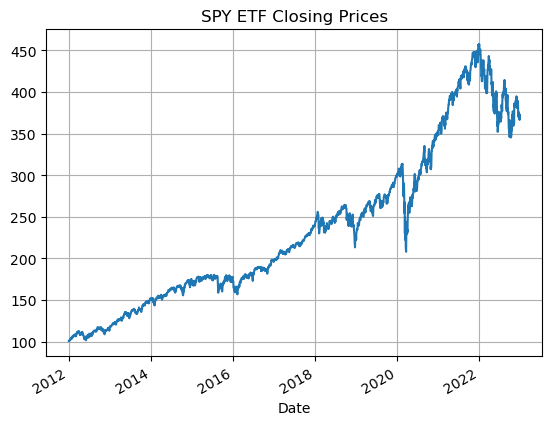

In [41]:
equity.plot()
plt.title("SPY ETF Closing Prices")
plt.grid()

The equity ETF sees an almost continuous rise in its prices except for a sharp dip in early 2020, which coincides with the first wave of the covid pandemic. There is also a dip in 2022.

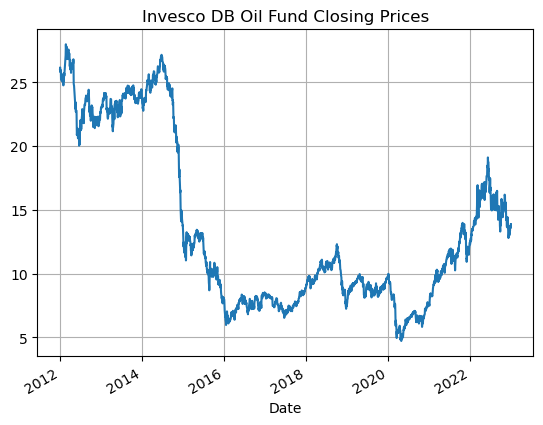

In [44]:
crude_oil.plot()
plt.title("Invesco DB Oil Fund Closing Prices")
plt.grid()

The Invesco Crude Oil ETF sees the sharp fall in the mid 2010s and then sees movement within a range for the remainder of the time period under consideration.

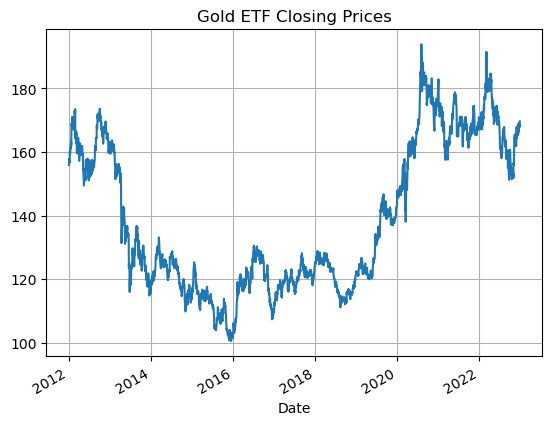

In [47]:
gold.plot()
plt.title("Gold ETF Closing Prices")
plt.grid()

The Gold ETF sees a dip in the early 2010s, then stays flat before rising starting in 2018.

Let us have a look at the skew and the kurtosis of all 3 ETFs

In [51]:
print("The skew and kurtosis in the Equity ETF data is {0} and {1} respectively".format(equity.skew(), equity.kurtosis()))
print("The skew and kurtosis in the Oil ETF data is {0} and {1} respectively".format(crude_oil.skew(), crude_oil.kurtosis()))
print("The skew and kurtosis in the Gold ETF data is {0} and {1} respectively".format(gold.skew(), gold.kurtosis()))

The skew and kurtosis in the Equity ETF data is 0.6422238374377048 and -0.6606505418082862 respectively
The skew and kurtosis in the Oil ETF data is 0.7384448547434744 and -0.9998038365320361 respectively
The skew and kurtosis in the Gold ETF data is 0.39954065132761857 and -1.3152042787043552 respectively


Now, let us check for the stationarity of each series individually

In [54]:
#First, the Equity ETF
adf_result_equity = adfuller(equity)
adf_statistic = adf_result_equity[0] 
p_value = adf_result_equity[1]
used_lags = adf_result_equity[2] 
critical_values = adf_result_equity[4] 

adf_statistic, p_value, used_lags, critical_values

(-0.5905007339705436,
 0.8731140571900827,
 27,
 {'1%': -3.43273884556851,
  '5%': -2.8625954199228967,
  '10%': -2.567331834008205})

In [56]:
#Second, the Oil ETF
adf_result_crude_oil = adfuller(crude_oil)
adf_statistic = adf_result_crude_oil[0] 
p_value = adf_result_crude_oil[1]
used_lags = adf_result_crude_oil[2] 
critical_values = adf_result_crude_oil[4] 

adf_statistic, p_value, used_lags, critical_values

(-1.8839062658178596,
 0.339669572182173,
 1,
 {'1%': -3.432716369874773,
  '5%': -2.8625854938408413,
  '10%': -2.5673265493658404})

In [58]:
#Finally, the Gold ETF
adf_result_gold = adfuller(gold)
adf_statistic = adf_result_gold[0] 
p_value = adf_result_gold[1]
used_lags = adf_result_gold[2] 
critical_values = adf_result_gold[4] 

adf_statistic, p_value, used_lags, critical_values

(-1.3375143748927665,
 0.6118395523429857,
 0,
 {'1%': -3.4327155138680454,
  '5%': -2.8625851157957265,
  '10%': -2.5673263480950106})

None of the three series are stationary. For all the three series, the ADF statistic is larger than the critical values and the p-value is greater than 0.05. 

Let us check for the persistence of each time series

In [62]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(equity.autocorr(lag = i))

0.9995227181904976
0.9978916491952624
0.9959237329414968
0.9836716122287105
0.9724906323012308
0.9362630964549714
0.9241349657495127
0.9391750890903247


In [64]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(gold.autocorr(lag = i))

0.998293142192759
0.9915596896491187
0.9842318017766246
0.9303872797771524
0.8664537468422341
0.7330396037892724
0.20605224282567552
-0.4259101875055885


In [66]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(crude_oil.autocorr(lag = i))

0.9993631664096375
0.997084307779231
0.9939891286624676
0.9575816129410109
0.9071803272444522
0.7864044472512508
0.30654351922929163
-0.2881522161082544


There appears to be considerable autocorrelation in all the three time series.

Let us plot the histrograms for all three series

Text(0.5, 1.0, 'Distribution of Closing Prices of the SPY ETF')

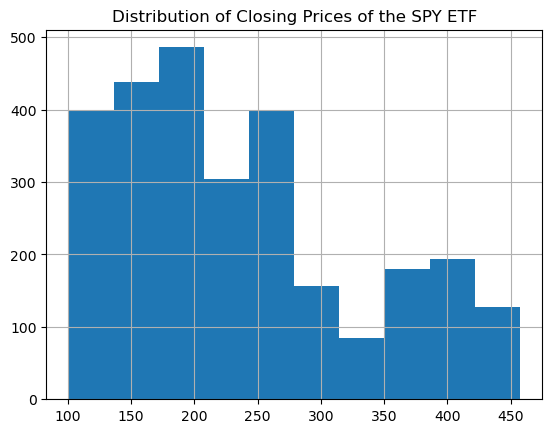

In [70]:
equity.hist()
plt.title("Distribution of Closing Prices of the SPY ETF")

Text(0.5, 1.0, 'Distribution of Closing Prices of the oil ETF')

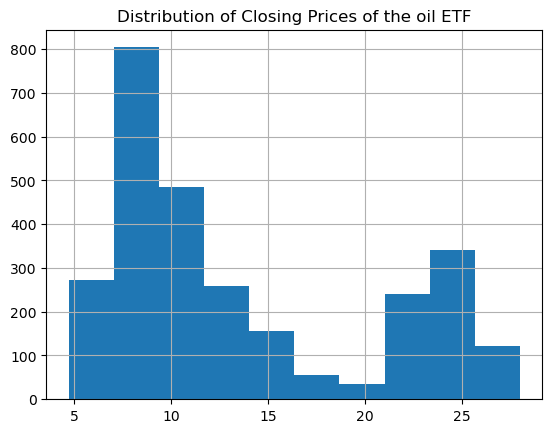

In [71]:
crude_oil.hist()
plt.title("Distribution of Closing Prices of the oil ETF")

Text(0.5, 1.0, 'Distribution of Closing Prices of the Gold ETF')

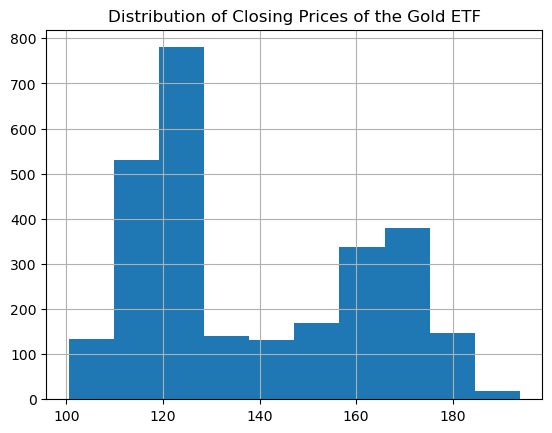

In [73]:
gold.hist()
plt.title("Distribution of Closing Prices of the Gold ETF")

Now, let us look at the scatterplots and the correlations of the series pairwise

In [77]:
gold.corr(equity)

0.5351892382794802

In [79]:
gold.corr(crude_oil)

0.13426845249777306

In [81]:
equity.corr(crude_oil)

-0.45073660941246946

The Equity and Crude Oil ETFs are negatively correlated with each other, meaning that one goes down while the other goes up. This may be explained by the fact that stock markets usually see a downturn when oil prices go up as the latter generally eats into company profits.
The correlation between the Crude Oil and Gold WTFs is a very mild 0.13. The Equity and gold ETFs on the other hand are moderately positively correlated.

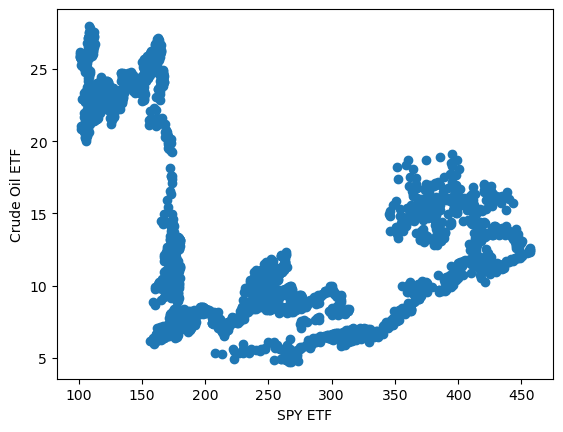

In [84]:
plt.scatter(equity, crude_oil)
plt.xlabel("SPY ETF")
plt.ylabel("Crude Oil ETF");

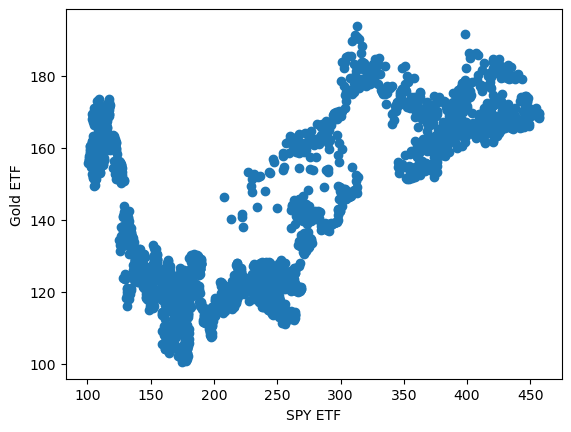

In [86]:
plt.scatter(equity, gold)
plt.xlabel("SPY ETF")
plt.ylabel("Gold ETF");

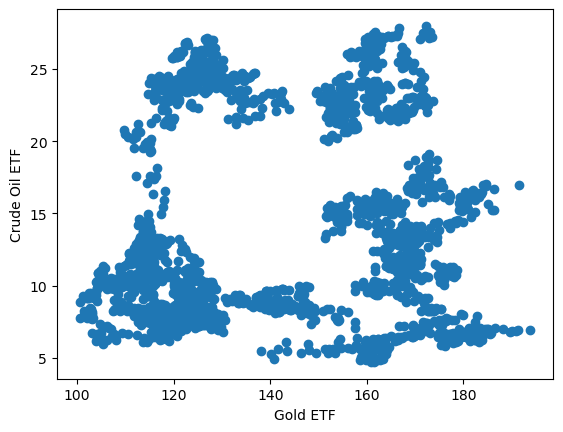

In [88]:
plt.scatter(gold, crude_oil)
plt.xlabel("Gold ETF")
plt.ylabel("Crude Oil ETF");

## Step 2

Let us now build the LSTM model separately for each time series

First, we try model-building using just the vanilla time series

In [468]:
equity_data = equity.to_frame()

In [470]:
equity_data.tail()

,Close
Date,
2022-12-23 00:00:00-05:00,372.400482
2022-12-27 00:00:00-05:00,370.931976
2022-12-28 00:00:00-05:00,366.322052
2022-12-29 00:00:00-05:00,372.915985
2022-12-30 00:00:00-05:00,371.933716


We define the train, test and validation samples

In [473]:
val_split = 0.15
train_set = equity_data[equity_data.index < "2018-01-01"] #data until the end of 2017
test_set = equity_data[equity_data.index > "2018-01-01"] #data from 2018 to 20222

train_split = len(train_set)/len(equity_data)
test_split = len(test_set)/len(equity_data)
train_size = int(len(equity_data) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(equity_data) - train_size)
print("Train-test split:", train_split, test_split)

Train-test split: 0.5451589595375722 0.45484104046242774


In [475]:
len(equity_data[equity_data.index > "2018-01-01"])

1259

In [477]:
equity_data.head()

,Close
Date,
2012-01-03 00:00:00-05:00,100.752861
2012-01-04 00:00:00-05:00,100.910866
2012-01-05 00:00:00-05:00,101.179573
2012-01-06 00:00:00-05:00,100.918800
2012-01-09 00:00:00-05:00,101.163780


In [479]:
window_size = 25

In [481]:
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.transform(test_set)

In [483]:
X_train = []
y_train = [] 

X_test = []
y_test = [] 

for i in range(window_size, train_set.shape[0]):
    X_train.append(train_set[i-window_size: i])
    y_train.append(train_set[i, 0])

for i in range(window_size, test_set.shape[0]):
    X_test.append(test_set[i-window_size: i])
    y_test.append(test_set[i, 0])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [485]:
X_train, y_train = np.array(X_train), np.array(y_train) 
X_test, y_test = np.array(X_test), np.array(y_test)

Now, let us build a basic LSTM model

In [488]:
seed = 1234
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train.shape[1], 1),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [490]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))

In [492]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_43 (LSTM)                       │ (None, 25, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_44 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_45 (LSTM)                       │ (None, 25, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_46 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_47 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,609 (4.35 MB)

 Trainable params: 1,140,609 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [494]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 14s - 698ms/step - loss: 0.2234 - val_loss: 0.0814
Epoch 2/100
20/20 - 3s - 167ms/step - loss: 0.0767 - val_loss: 0.1039
Epoch 3/100
20/20 - 3s - 174ms/step - loss: 0.0325 - val_loss: 0.0230
Epoch 4/100
20/20 - 3s - 163ms/step - loss: 0.0222 - val_loss: 0.0173
Epoch 5/100
20/20 - 3s - 171ms/step - loss: 0.0209 - val_loss: 0.0212
Epoch 6/100
20/20 - 3s - 166ms/step - loss: 0.0208 - val_loss: 0.0209
Epoch 7/100
20/20 - 3s - 172ms/step - loss: 0.0204 - val_loss: 0.0345
Epoch 8/100
20/20 - 3s - 168ms/step - loss: 0.0212 - val_loss: 0.0224
Epoch 9/100
20/20 - 3s - 164ms/step - loss: 0.0205 - val_loss: 0.0266


Let us now test the predictions of this model on the training data as well as the test data

In [496]:
train_pred = model.predict(X_train)
print("r2 score of the model on the in-sample set:", r2_score(y_train, train_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_train, train_pred.flatten()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
r2 score of the model on the in-sample set: 0.9874582689293535
correlation between the predicted values and the actual in-sample data: [[1.        0.9942944]
 [0.9942944 1.       ]]


In [497]:
y_pred = model.predict(X_test)
print("r2 score of the model on the out-of-sample test set:", r2_score(y_test, y_pred))
print("correlation between the predicted values and the actual out-of-sample data:", np.corrcoef(y_test, y_pred.flatten()))

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
r2 score of the model on the out-of-sample test set: 0.9491672322060475
correlation between the predicted values and the actual out-of-sample data: [[1.         0.97902342]
 [0.97902342 1.        ]]


In [498]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

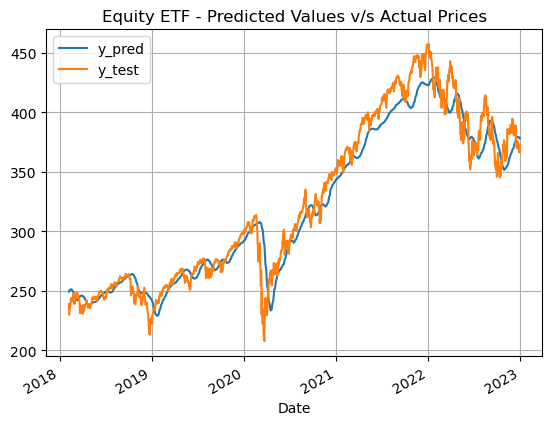

In [499]:
equity_pred = pd.DataFrame()
equity_pred["y_pred"] = (pd.DataFrame(y_pred))
equity_pred["y_test"] = pd.DataFrame(y_test)
equity_pred.index = equity_data[train_size+26:].index
equity_pred.plot()
plt.title("Equity ETF - Predicted Values v/s Actual Prices");
plt.grid()
plt.savefig("equity_plot.png")

Modeling the Crude Oil ETF

In [601]:
crude_oil_data = crude_oil.to_frame()

In [603]:
train_set = crude_oil_data[crude_oil_data.index < "2018-01-01"] #data until the end of 2017
test_set = crude_oil_data[crude_oil_data.index > "2018-01-01"] #data from 2018 to 2022

In [605]:
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.transform(test_set)

In [607]:
X_train = []
y_train = [] 

X_test = []
y_test = [] 

for i in range(window_size, train_set.shape[0]):
    X_train.append(train_set[i-window_size: i])
    y_train.append(train_set[i, 0])

for i in range(window_size, test_set.shape[0]):
    X_test.append(test_set[i-window_size: i])
    y_test.append(test_set[i, 0])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [609]:
X_train, y_train = np.array(X_train), np.array(y_train) 
X_test, y_test = np.array(X_test), np.array(y_test)

Model Building

In [612]:
seed = 1234
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train.shape[1], 1),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [614]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(1))

In [616]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_57 (LSTM)                       │ (None, 25, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_58 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_59 (LSTM)                       │ (None, 25, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_60 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 711,553 (2.71 MB)

 Trainable params: 711,553 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

In [618]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=15, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 8s - 398ms/step - loss: 0.3993 - val_loss: 0.1036
Epoch 2/100
20/20 - 2s - 104ms/step - loss: 0.1066 - val_loss: 0.1173
Epoch 3/100
20/20 - 2s - 104ms/step - loss: 0.0539 - val_loss: 0.0128
Epoch 4/100
20/20 - 2s - 102ms/step - loss: 0.0343 - val_loss: 0.0128
Epoch 5/100
20/20 - 2s - 112ms/step - loss: 0.0330 - val_loss: 0.0122
Epoch 6/100
20/20 - 2s - 108ms/step - loss: 0.0328 - val_loss: 0.0124
Epoch 7/100
20/20 - 2s - 106ms/step - loss: 0.0329 - val_loss: 0.0122
Epoch 8/100
20/20 - 2s - 105ms/step - loss: 0.0330 - val_loss: 0.0123
Epoch 9/100
20/20 - 2s - 112ms/step - loss: 0.0321 - val_loss: 0.0121
Epoch 10/100
20/20 - 2s - 125ms/step - loss: 0.0320 - val_loss: 0.0120
Epoch 11/100
20/20 - 2s - 109ms/step - loss: 0.0325 - val_loss: 0.0119
Epoch 12/100
20/20 - 2s - 115ms/step - loss: 0.0319 - val_loss: 0.0119
Epoch 13/100
20/20 - 2s - 103ms/step - loss: 0.0313 - val_loss: 0.0128
Epoch 14/100
20/20 - 2s - 104ms/step - loss: 0.0311 - val_loss: 0.0117
Epoch 15/100
20

Let us now test the predictions of this model on the training data as well as the test data

In [621]:
train_pred = model.predict(X_train)
print("r2 score of the model on the in-sample set:", r2_score(y_train, train_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_train, train_pred.flatten()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
r2 score of the model on the in-sample set: 0.9945181277399819
correlation between the predicted values and the actual in-sample data: [[1.         0.99749634]
 [0.99749634 1.        ]]


In [622]:
y_pred = model.predict(X_test)
print("r2 score of the model on the out-of-sample test set:", r2_score(y_test, y_pred))
print("correlation between the predicted values and the actual out-of-sample data:", np.corrcoef(y_test, y_pred.flatten()))

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
r2 score of the model on the out-of-sample test set: 0.9709867409824722
correlation between the predicted values and the actual out-of-sample data: [[1.         0.98600846]
 [0.98600846 1.        ]]


In [625]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

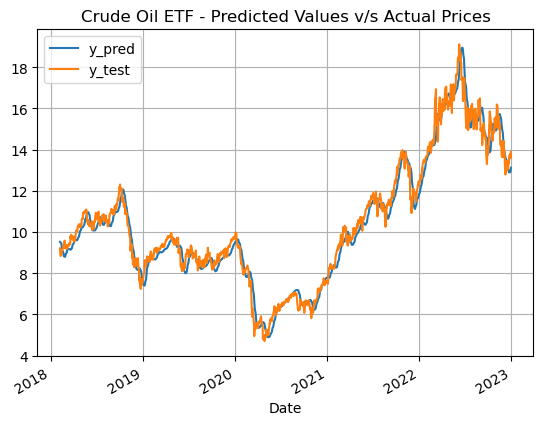

In [627]:
crude_oil_pred = pd.DataFrame()
crude_oil_pred["y_pred"] = pd.DataFrame(y_pred)
crude_oil_pred["y_test"] = pd.DataFrame(y_test)
crude_oil_pred.index = crude_oil_data[train_size+26:].index
crude_oil_pred.plot()
plt.grid()
plt.title("Crude Oil ETF - Predicted Values v/s Actual Prices");
plt.savefig("Crude_oil_plot.png")

Modeling the prices of the Gold ETF

In [629]:
gold_data = gold.to_frame()

In [631]:
gold_data.tail()

,Close
Date,
2022-12-23 00:00:00-05:00,167.259995
2022-12-27 00:00:00-05:00,168.669998
2022-12-28 00:00:00-05:00,167.910004
2022-12-29 00:00:00-05:00,168.850006
2022-12-30 00:00:00-05:00,169.639999


In [633]:
train_set = gold_data[gold_data.index < "2018-01-01"] #data until the end of 2017
test_set = gold_data[gold_data.index > "2018-01-01"] #data from 2018 to 20222

In [635]:
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.transform(test_set)

In [637]:
X_train = []
y_train = [] 

X_test = []
y_test = [] 

for i in range(window_size, train_set.shape[0]):
    X_train.append(train_set[i-window_size: i])
    y_train.append(train_set[i, 0])

for i in range(window_size, test_set.shape[0]):
    X_test.append(test_set[i-window_size: i])
    y_test.append(test_set[i, 0])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [639]:
X_train, y_train = np.array(X_train), np.array(y_train) 
X_test, y_test = np.array(X_test), np.array(y_test)

In [641]:
seed = 1234
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train.shape[1], 1),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [643]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))

In [645]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                       │ (None, 25, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_62 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_63 (LSTM)                       │ (None, 25, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_64 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_65 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,609 (4.35 MB)

 Trainable params: 1,140,609 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [647]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 11s - 563ms/step - loss: 0.2455 - val_loss: 0.1296
Epoch 2/100
20/20 - 3s - 173ms/step - loss: 0.0790 - val_loss: 0.0303
Epoch 3/100
20/20 - 4s - 179ms/step - loss: 0.0503 - val_loss: 0.0400
Epoch 4/100
20/20 - 3s - 169ms/step - loss: 0.0490 - val_loss: 0.0290
Epoch 5/100
20/20 - 3s - 160ms/step - loss: 0.0509 - val_loss: 0.0298
Epoch 6/100
20/20 - 3s - 158ms/step - loss: 0.0496 - val_loss: 0.0307
Epoch 7/100
20/20 - 3s - 162ms/step - loss: 0.0495 - val_loss: 0.0294
Epoch 8/100
20/20 - 3s - 165ms/step - loss: 0.0466 - val_loss: 0.0291
Epoch 9/100
20/20 - 3s - 164ms/step - loss: 0.0463 - val_loss: 0.0289
Epoch 10/100
20/20 - 3s - 158ms/step - loss: 0.0454 - val_loss: 0.0293
Epoch 11/100
20/20 - 3s - 161ms/step - loss: 0.0449 - val_loss: 0.0299
Epoch 12/100
20/20 - 3s - 163ms/step - loss: 0.0451 - val_loss: 0.0294
Epoch 13/100
20/20 - 3s - 162ms/step - loss: 0.0492 - val_loss: 0.0284
Epoch 14/100
20/20 - 3s - 161ms/step - loss: 0.0444 - val_loss: 0.0278
Epoch 15/100
2

Let us check the performance of the model on the train and test time periods.

In [649]:
train_pred = model.predict(X_train)
print("r2 score of the model on the in-sample set:", r2_score(y_train, train_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_train, train_pred.flatten()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
r2 score of the model on the in-sample set: 0.9793625389192253
correlation between the predicted values and the actual in-sample data: [[1.         0.98987077]
 [0.98987077 1.        ]]


In [650]:
y_pred = model.predict(X_test)
print("r2 score of the model on the out-of-sample test set:", r2_score(y_test, y_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_test, y_pred.flatten()))

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
r2 score of the model on the out-of-sample test set: 0.9834494948058928
correlation between the predicted values and the actual in-sample data: [[1.         0.99172954]
 [0.99172954 1.        ]]


In [655]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

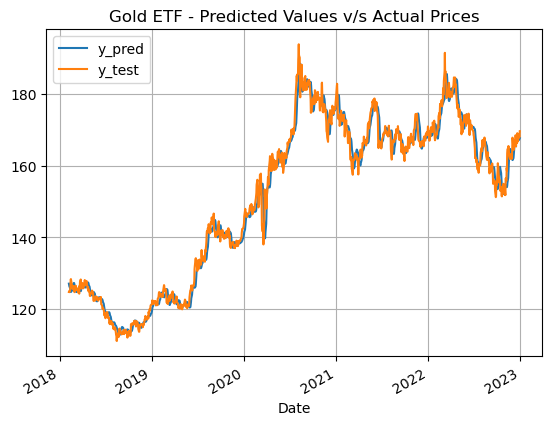

In [657]:
gold_pred = pd.DataFrame()
gold_pred["y_pred"] = pd.DataFrame(y_pred)
gold_pred["y_test"] = pd.DataFrame(y_test)
gold_pred.index = gold_data[train_size+26:].index
gold_pred.plot()
plt.grid()
plt.title("Gold ETF - Predicted Values v/s Actual Prices");
plt.savefig("gold_plot.png")

Now, that we have the model's predicted prices on the test data, let us compute the 25 day returns that the model effectively predicts. We then use the "MaxProfit" strategy in order to compute the returns we get over the period from 2018 to 2022.

In [664]:
equity_returns = equity_pred.pct_change(-25)
crude_oil_returns = crude_oil_pred.pct_change(-25)
gold_returns = gold_pred.pct_change(-25)
equity_returns.dropna(inplace=True)
crude_oil_returns.dropna(inplace=True)
gold_returns.dropna(inplace=True)

In [666]:
max_profit_strategy_returns = 1
#buy_and_hold_strategy_returns = 
for i in range(0, equity_returns.shape[0], 25):
    best_return_projections = pd.Series([equity_returns.iloc[i, 0], crude_oil_returns.iloc[i, 0], gold_returns.iloc[i, 0]]).argmax()
    if best_return_projections == 0:
        max_profit_strategy_returns *= (1 + equity_returns.iloc[i, 1])
    elif best_return_projections == 1:
        max_profit_strategy_returns *= (1 + crude_oil_returns.iloc[i, 1])
    else:
        max_profit_strategy_returns *= (1 + gold_returns.iloc[i, 1])
print((max_profit_strategy_returns - 1)*100)

294.8170604220626


The trading strategy that is used here is as follows: on the first trading day of the test time period, we first compute the predicted 25-day returns that the model computes for each of the three LSTM models. I compare the projected 25-day returns for each of the three ETFs, and choose the ETF for which the projected returns are the highest. I then calculate the percentage returns we would have got in 25 days if we actually brought the ETF chosen previously. This is one iteration of the strategy, and this continues for the remainder of the duration of the time period. At the beginning of each successive set of 25 trading days, the projected 25-day returns for each ETF is computed and the best one is chosen. The actual returns that that ETF gives in the next 25 days is calculated. Over the time period slotted for backtesting (Jan 2018 to December 2022), this amounts to a little more than 1200 trading days, and so, our strategy gets recalibrated 48 times during this time.


Using the MaxProfit trading strategy, we effectively end up multiplying by initial invesment by around 3 times. Our returns are a whopping 294% over five years.

Let us compare this to the buy-and-hold strategy. Here, we buy an equally weighted portfolio of the 3 ETFs and hold it over the duration of the test period. We sell it at the end of the test period. Let us compute the results we obtain.

In [671]:
#Buy-Hold-Strategy
equity_bh_returns = (equity_pred.iloc[-1, 1] - equity_pred.iloc[0, 1])/(equity_pred.iloc[0, 1])*100
crude_oil_bh_returns = (crude_oil_pred.iloc[-1, 1] - crude_oil_pred.iloc[0, 1])/(crude_oil_pred.iloc[0, 1])*100
gold_bh_returns = (gold_pred.iloc[-1, 1] - gold_pred.iloc[0, 1])/(gold_pred.iloc[0, 1])*100
print("Buy and Hold Strategy - Equity Returns in Percentage", equity_bh_returns)
print("Buy and Hold Strategy - Crude Oil Returns in Percentage", crude_oil_bh_returns)
print("Buy and Hold Strategy - Gold Returns in Percentage", gold_bh_returns)
average_bh_returns = (equity_bh_returns + crude_oil_bh_returns + gold_bh_returns)/3
print("Buy and Hold Strategy - Equally Weighted Portfolio Returns in Percentage", average_bh_returns)

Buy and Hold Strategy - Equity Returns in Percentage 55.61325098328228
Buy and Hold Strategy - Crude Oil Returns in Percentage 50.799885485019004
Buy and Hold Strategy - Gold Returns in Percentage 35.94037835169252
Buy and Hold Strategy - Equally Weighted Portfolio Returns in Percentage 47.451171606664595


If we had followed the buy and hold strategy, our returns over the years from 2018 to 2022 would ahve been 47.45%

In [673]:
gold_pred.iloc[-1]

y_pred    167.735840
y_test    169.639999
Name: 2022-12-30 00:00:00-05:00, dtype: float64

## Step 3

Now, for the multi-output DL Model

In [694]:
data = pd.DataFrame()
data["equity"] = equity
data["crude_oil"] = crude_oil
data["gold"] = gold

In [696]:
data

,equity,crude_oil,gold
Date,,,
2012-01-03 00:00:00-05:00,100.752861,26.042212,155.919998
2012-01-04 00:00:00-05:00,100.910866,26.165094,156.710007
2012-01-05 00:00:00-05:00,101.179573,25.814003,157.779999
2012-01-06 00:00:00-05:00,100.918800,25.919331,157.199997
2012-01-09 00:00:00-05:00,101.163780,25.831558,156.500000
...,...,...,...
2022-12-23 00:00:00-05:00,372.400482,13.693008,167.259995
2022-12-27 00:00:00-05:00,370.931976,13.793423,168.669998
2022-12-28 00:00:00-05:00,366.322052,13.647365,167.910004


In [698]:
train_set = data[equity_data.index < "2018-01-01"] #data until the end of 2017
test_set = data[equity_data.index > "2018-01-01"] #data from 2018 to 2022

In [700]:
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.transform(test_set)

In [702]:
X_train = []
y_train = [] 

X_test = []
y_test = [] 

for i in range(window_size, train_set.shape[0]):
    X_train.append(train_set[i-window_size: i])
    y_train.append(train_set[i])

for i in range(window_size, test_set.shape[0]):
    X_test.append(test_set[i-window_size: i])
    y_test.append(test_set[i])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [704]:
X_train, y_train = np.array(X_train), np.array(y_train) 
X_test, y_test = np.array(X_test), np.array(y_test)

In [706]:
seed = 1234
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train.shape[1], 3),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [708]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(3))

In [710]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_71 (LSTM)                       │ (None, 25, 128)             │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_72 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_73 (LSTM)                       │ (None, 25, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_74 (LSTM)                       │ (None, 25, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_75 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,600,963 (6.11 MB)

 Trainable params: 1,600,963 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [712]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 13s - 645ms/step - loss: 0.2873 - val_loss: 0.2786
Epoch 2/100
20/20 - 4s - 200ms/step - loss: 0.1503 - val_loss: 0.1904
Epoch 3/100
20/20 - 4s - 212ms/step - loss: 0.0829 - val_loss: 0.0956
Epoch 4/100
20/20 - 4s - 205ms/step - loss: 0.0485 - val_loss: 0.0442
Epoch 5/100
20/20 - 4s - 199ms/step - loss: 0.0383 - val_loss: 0.0522
Epoch 6/100
20/20 - 4s - 208ms/step - loss: 0.0359 - val_loss: 0.0482
Epoch 7/100
20/20 - 5s - 232ms/step - loss: 0.0353 - val_loss: 0.0499
Epoch 8/100
20/20 - 4s - 207ms/step - loss: 0.0352 - val_loss: 0.0474
Epoch 9/100
20/20 - 4s - 206ms/step - loss: 0.0354 - val_loss: 0.0487


In [714]:
train_pred = model.predict(X_train)
print("r2 score of the model on the in-sample set on the equity ETF:", r2_score(y_train[0], train_pred[0]))
print("correlation between the predicted values and the actual in-sample data on the equity ETF:", np.corrcoef(y_train[0], train_pred[0]))
print("r2 score of the model on the in-sample set on the crude oil ETF:", r2_score(y_train[1], train_pred[1]))
print("correlation between the predicted values and the actual in-sample data on the crude oil ETF:", np.corrcoef(y_train[1], train_pred[1]))
print("r2 score of the model on the in-sample set on the gold ETF:", r2_score(y_train[2], train_pred[2]))
print("correlation between the predicted values and the actual in-sample data on the gold ETF:", np.corrcoef(y_train[2], train_pred[2]))

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
r2 score of the model on the in-sample set on the equity ETF: 0.985432967832402
correlation between the predicted values and the actual in-sample data on the equity ETF: [[1.         0.99416078]
 [0.99416078 1.        ]]
r2 score of the model on the in-sample set on the crude oil ETF: 0.9905269771960851
correlation between the predicted values and the actual in-sample data on the crude oil ETF: [[1.         0.99650918]
 [0.99650918 1.        ]]
r2 score of the model on the in-sample set on the gold ETF: 0.9945252885201907
correlation between the predicted values and the actual in-sample data on the gold ETF: [[1.         0.99757423]
 [0.99757423 1.        ]]


In [716]:
test_pred = model.predict(X_test)
print("r2 score of the model on the out-of-sample set on the equity ETF:", r2_score(y_test[0], test_pred[0]))
print("correlation between the predicted values and the actual out-of-sample data on the equity ETF:", np.corrcoef(y_test[0], test_pred[0]))
print("r2 score of the model on the out-of-sample set on the crude oil ETF:", r2_score(y_test[1], test_pred[1]))
print("correlation between the predicted values and the actual out-of-sample data on the crude oil ETF:", np.corrcoef(y_test[1], test_pred[1]))
print("r2 score of the model on the out-of-sample set on the gold ETF:", r2_score(y_test[2], test_pred[2]))
print("correlation between the predicted values and the actual out-of-sample data on the gold ETF:", np.corrcoef(y_test[2], test_pred[2]))

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
r2 score of the model on the out-of-sample set on the equity ETF: 0.9764013302963287
correlation between the predicted values and the actual out-of-sample data on the equity ETF: [[1.         0.99356127]
 [0.99356127 1.        ]]
r2 score of the model on the out-of-sample set on the crude oil ETF: 0.9931206047050434
correlation between the predicted values and the actual out-of-sample data on the crude oil ETF: [[1.         0.99662268]
 [0.99662268 1.        ]]
r2 score of the model on the out-of-sample set on the gold ETF: 0.9902847741825155
correlation between the predicted values and the actual out-of-sample data on the gold ETF: [[1.        0.9962898]
 [0.9962898 1.       ]]


In [720]:
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(test_pred)

In [722]:
multi_output_real_prices = pd.DataFrame(y_test)
multi_output_pred_prices = pd.DataFrame(y_pred)

In [724]:
multi_output_real_prices.columns = [["Equity ETF", "Crude Oil ETF", "Gold ETF"]]
multi_output_pred_prices.columns = [["Equity ETF", "Crude Oil ETF", "Gold ETF"]]
multi_output_real_prices.index = data[train_size+26:].index
multi_output_pred_prices.index = data[train_size+26:].index

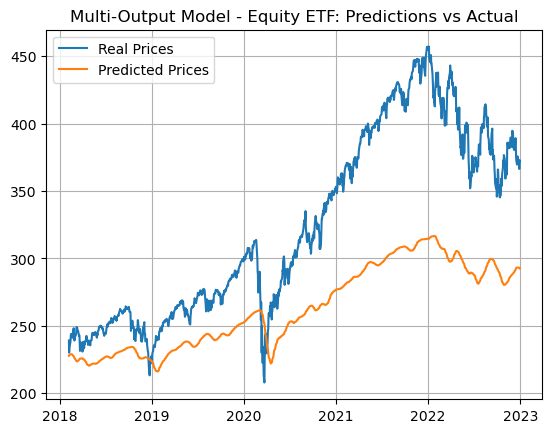

In [726]:
plt.plot(multi_output_real_prices["Equity ETF"])
plt.plot(multi_output_pred_prices["Equity ETF"])
plt.legend(["Real Prices", "Predicted Prices"])
plt.title("Multi-Output Model - Equity ETF: Predictions vs Actual")
plt.grid()
plt.savefig("Multi-Output Model - Equity ETF .png")

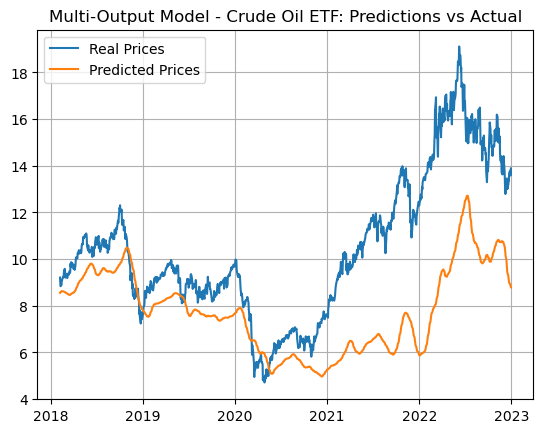

In [728]:
plt.plot(multi_output_real_prices["Crude Oil ETF"])
plt.plot(multi_output_pred_prices["Crude Oil ETF"])
plt.legend(["Real Prices", "Predicted Prices"])
plt.grid()
plt.title("Multi-Output Model - Crude Oil ETF: Predictions vs Actual")
plt.savefig("Multi-Output Model - Crude Oil ETF .png")

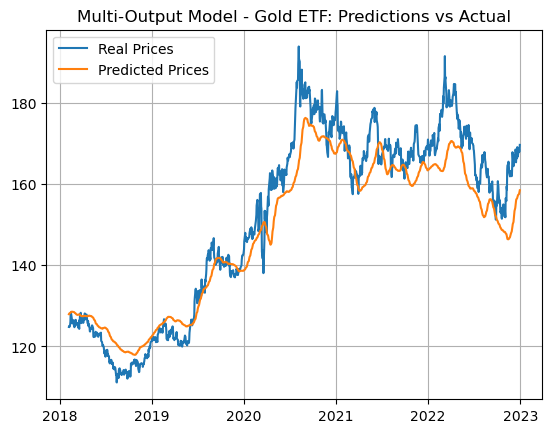

In [730]:
plt.plot(multi_output_real_prices["Gold ETF"])
plt.plot(multi_output_pred_prices["Gold ETF"])
plt.legend(["Real Prices", "Predicted Prices"])
plt.grid()
plt.title("Multi-Output Model - Gold ETF: Predictions vs Actual")
plt.savefig("Multi-Output Model - Gold ETF .png")

In [732]:
real_25d_ret = multi_output_real_prices.pct_change(-25)
pred_25d_ret = multi_output_pred_prices.pct_change(-25)

In [734]:
real_25d_ret.dropna(inplace=True)
pred_25d_ret.dropna(inplace=True)

In [739]:
max_profit_strategy_cumulative_amount = 1
for i in range(0, pred_25d_ret.shape[0], 25):
    best_return_projections = (abs(pred_25d_ret.iloc[i, :])).argmax()
    max_profit_strategy_cumulative_amount *= (1 + real_25d_ret.iloc[i, best_return_projections])
    #print(max_profit_strategy_returns)
print(max_profit_strategy_cumulative_amount*100)

60.2262124777197


As you can see here, using the MaxProfit Trading Strategy (which was used earlier for the models in Step 2) here decreases our initial investment amount to 60.22% of it's original at the beginning of the testing time period. This implies that we encur a loss of 54% over the period from 2018 to 2022 should we follow this strategy on the multi-output model.